In [58]:
import pytrec_eval,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk, imdb
from nameparser.parser import HumanName
from nltk.corpus import wordnet


In [59]:
import warnings
warnings.filterwarnings("ignore")

## Lendo os dados DEV

In [60]:
# read queries
queries = pd.read_json('./results/dev_queries.jsonl', lines=True)

# read the results file
with open('./results/trec_rerank_dense_my_data_with_cool_corpus.csv', 'r') as f_run:
    run = pytrec_eval.parse_run(f_run)

# read qrels
with open('./results/qrel.txt', 'r') as f_qrel:
    qrel = pytrec_eval.parse_qrel(f_qrel)

#evaluate
evaluator = pytrec_eval.RelevanceEvaluator(
    qrel, pytrec_eval.supported_measures
)
results = evaluator.evaluate(run)

results['152']['ndcg']

0.3562071871080222

## Lendo os dados TEST

In [61]:
def read_run(queries_filepath: str) -> dict[dict]:
    """
    read eval of my run
    """
    results = {}

    with open(queries_filepath, 'r') as f_run:
        for line in f_run:
            metric, query, score = line.split()
            if re.match(r"\d",score) and not re.match(r"all",query):
                if not query in results:
                    results[query] = {}    
                results[query][metric] = float(score)
    
    return results

In [62]:
# queries = pd.read_json('./results/test_queries.jsonl', lines=True)
# results = read_run('./results/trec_evals/ufmgDBmBQD.eval')

# print(results.keys())

# Vamos mostrar os resultados retornados pela TREC:

In [63]:
# filepaths = ['./results/trec_evals/ufmgDBmBQ.eval', './results/trec_evals/ufmgDBmBQD.eval', './results/trec_evals/ufmgDBmBdTQD.eval', './results/trec_evals/ufmgG4mBQD.eval', './results/trec_evals/ufmgG4dTQD.eval']

# mean_run = []
# for filepath in filepaths:
#     partial_results = read_run(filepath)

#     mean_run.append(partial_results['all'])

# df = pd.DataFrame(mean_run, index = ['ufmgDBmBQ', 'ufmgDBmBQD', 'ufmgDBmBdTQD', 'ufmgG4mBQD', 'ufmgG4dTQD'])
# df[['ndcg', 'recip_rank','recall_1000']]


# Analisar sentence annotations: 

Eles moscam em um monte de coisa, não marcaram a sentença com data como temporal, varias tem plot o que não foi marcado, uma fala que é r rated e nada de falar que tem genre audience

In [64]:
sentences= len(queries.iloc[5]['sentence_annotations'])

for i in range(sentences):
    print(queries.iloc[5]['sentence_annotations'][i]['text'])
    for key, value in queries.iloc[3]['sentence_annotations'][i]['labels']['movie'].items():
        if value:
            print(key, ":", value)
    for key, value in queries.iloc[3]['sentence_annotations'][i]['labels']['context'].items():
        if value:
            print(key, ":", value)
    print("=========================================================")


Ive had a movie on my mind for a few days I watcher several years back (at least 10+) I dont remember alot of it, but there was a guy chased by cops for superlong and at one point it was in a desert environment.
category : True
He mustve had several dozen of cops right behind him at one point and when it looked like he was about to get caught a trucker showed up in a far distans, shortly after several others showed up behind it and they spread out in a line.
genre_traditional_tone : True
Im not sure but I think he was driving an american muscle car, it was for sure an american movie, colored, and if I had to guess maybe from the 80’s or 90’s.
Id appreciate any help on this, going crazy over here!


# Características das Consultas

Por meio de expressões regulares simples, vamos buscar por elementos comuns nas descrições de filme.


- Eu vou conseguir varias datas, pegar a do IMDB e concatenar com a data normalizada. Eg: Homem aranha é de 2003, vou por a data como 2003 2000
- Verificar classificação indicativa e talvez inferir (???) eu posso pegar um monte de filme do imdb pegar o par (plot-classificação indicativa) e tentar fazer um classificador pra classificação indicativa? 
- Verificar genero e talvez inferir (???) eu posso pegar um monte de filme do imdb pegar o par (plot-genero) e tentar fazer um classificador pro genero? 
- Verificar media (Netflix, streaming, tv...)
- verificar linguagem
- Verificar premios
- Verificar nomes retirar os q forem marcados com comparação??

### Procurando datas nas consultas

In [65]:
def normalize_date(date):
    """
    We have this tendency of using different formats for the same date.
    One of those is using 's for decades, e.g. 80's, 90's, etc.
    This function normalizes the date to the format YYYY.
    """
    
    date = re.sub(r'(s|\')', '', date.lower())
    if len(date) == 2:
        date = '19' + date

    return date

In [66]:
# find dates in all of the queries
queries['date'] = False
queries['normalized_date'] = False

for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r'(\d{2}\'*`*’*s|\d{4}\'*s*)', content.lower())
    
    if match:
        queries.at[idx, 'date'] = ' '.join(match)
        queries.at[idx, 'normalized_date'] = ' '.join([normalize_date(date) for date in match])

queries.tail(2)

,id,url,domain,title,text,wikipedia_id,wikipedia_url,wikidata_id,imdb_url,sentence_annotations,date,normalized_date
148,385,https://irememberthismovie.com/flash-gun-killer/,movie,Flash Gun Killer,"I’m trying to find the name of a film, whereby...",2314982,https://en.wikipedia.org/wiki/Looker,Q668484,https://www.imdb.com/title/tt0082677,"[{'id': 1, 'text': 'I’m trying to find the nam...",1980s 1970s,1980 1970
149,521,https://irememberthismovie.com/ghost-story/,movie,Ghost story,There’s an old one I got to see just once as a...,2911505,https://en.wikipedia.org/wiki/Castle_of_Blood,Q2253504,https://www.imdb.com/title/tt0057993/,"[{'id': 1, 'text': 'There’s an old one I got t...",False,False


### Procurando por Classificação Indicativa

In [67]:
def infer_rating(content):
    pass   

In [68]:
# find mentions of parental rating

queries['parental_rating'] = False

for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r' (pg-13|pg|g rated|r rated)', content.lower())
    
    if match:
        queries.at[idx, 'parental_rating'] = ' '.join(match)
        # queries.at[idx, 'normalized_parental_rating'] = ' '.join(match)

queries.tail(2)

,id,url,domain,title,text,wikipedia_id,wikipedia_url,wikidata_id,imdb_url,sentence_annotations,date,normalized_date,parental_rating
148,385,https://irememberthismovie.com/flash-gun-killer/,movie,Flash Gun Killer,"I’m trying to find the name of a film, whereby...",2314982,https://en.wikipedia.org/wiki/Looker,Q668484,https://www.imdb.com/title/tt0082677,"[{'id': 1, 'text': 'I’m trying to find the nam...",1980s 1970s,1980 1970,False
149,521,https://irememberthismovie.com/ghost-story/,movie,Ghost story,There’s an old one I got to see just once as a...,2911505,https://en.wikipedia.org/wiki/Castle_of_Blood,Q2253504,https://www.imdb.com/title/tt0057993/,"[{'id': 1, 'text': 'There’s an old one I got t...",False,False,False


### Procurando gênero do filme nas consultas

In [69]:
genres = ['action', 'adventure', 'comedy', 'drama', 'fantasy', 'horror', 'musicals', 'mystery', 'romance', 'science fiction', 'sci-fi', 'sports', 'thriller', 'western']
queries['genre'] = False

# find mentions of genres
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    for genre in genres:
        match = re.findall(r' ' + genre, content.lower())
        if match:
            queries.at[idx, 'genre'] = " ".join(match)

queries.head(4)

,id,url,domain,title,text,wikipedia_id,wikipedia_url,wikidata_id,imdb_url,sentence_annotations,date,normalized_date,parental_rating,genre
0,152,https://irememberthismovie.com/foriegn-film-ab...,movie,Foriegn Film about 3 Strangers in an Apartment,Movie from the early 2000s I believe about th...,1940119,https://en.wikipedia.org/wiki/Vive_L%27Amour,Q711684,https://www.imdb.com/title/tt0109066,"[{'id': 1, 'text': 'Movie from the early 2000s...",2000s,2000,False,False
1,531,https://irememberthismovie.com/i-need-help/,movie,I need help,Alright so I saw this movie sometime in the ea...,30199617,https://en.wikipedia.org/wiki/Left_in_Darkness,Q2649653,https://www.imdb.com/title/tt0466875,"[{'id': 1, 'text': 'Alright so I saw this movi...",2000s,2000,False,False
2,473,https://irememberthismovie.com/horror-movie-wi...,movie,"horror movie with a old lady , possibly a ghos...",This is an older 80 s movie. Maybe early 90s. ...,15770244,https://en.wikipedia.org/wiki/Dead_Dudes_in_th...,Q971435,https://www.imdb.com/title/tt0101670,"[{'id': 1, 'text': 'This is an older 80 s movi...",90s,1990,False,False
3,659,https://irememberthismovie.com/funny-dads-dvd-...,movie,Funny dads- dvd cover of dads going down water...,I don’t really have any memory of this film. I...,35867054,https://en.wikipedia.org/wiki/Grown_Ups_2,Q5611721,https://www.imdb.com/title/tt2191701,"[{'id': 1, 'text': 'I don’t really have any me...",30’s 40s,30’ 1940,r rated,comedy comedy


#3 Procurando pela mídia do filme

In [70]:
media = r' (dvd|netflix|prime video|hbo|streaming|cinema|tv)'
queries['media'] = False

# find mentions of media
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(media, content.lower())
    if match:
        queries.at[idx, 'media'] = " ".join(match)

queries.head(2)

,id,url,domain,title,text,wikipedia_id,wikipedia_url,wikidata_id,imdb_url,sentence_annotations,date,normalized_date,parental_rating,genre,media
0,152,https://irememberthismovie.com/foriegn-film-ab...,movie,Foriegn Film about 3 Strangers in an Apartment,Movie from the early 2000s I believe about th...,1940119,https://en.wikipedia.org/wiki/Vive_L%27Amour,Q711684,https://www.imdb.com/title/tt0109066,"[{'id': 1, 'text': 'Movie from the early 2000s...",2000s,2000,False,False,False
1,531,https://irememberthismovie.com/i-need-help/,movie,I need help,Alright so I saw this movie sometime in the ea...,30199617,https://en.wikipedia.org/wiki/Left_in_Darkness,Q2649653,https://www.imdb.com/title/tt0466875,"[{'id': 1, 'text': 'Alright so I saw this movi...",2000s,2000,False,False,tv


### Procurando pela lingua original falada no filme

In [71]:
queries['language'] = False

# find mentions of language
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r' (english|spanish|french|german|italian|portuguese|japanese|chinese|korean|arabic|dutch|polish|turkish|indonesian|greek|norwegian|swedish|thai|finnish|hebrew|danish|czech|hungarian|vietnamese|romanian|swahili|icelandic|slovak|croatian|serbian|bulgarian|slovenian|lithuanian|latvian|estonian|esperanto)', content.lower())
    if match:
        queries.at[idx, 'language'] = " ".join(match)
    
queries.head(2)

,id,url,domain,title,text,wikipedia_id,wikipedia_url,wikidata_id,imdb_url,sentence_annotations,date,normalized_date,parental_rating,genre,media,language
0,152,https://irememberthismovie.com/foriegn-film-ab...,movie,Foriegn Film about 3 Strangers in an Apartment,Movie from the early 2000s I believe about th...,1940119,https://en.wikipedia.org/wiki/Vive_L%27Amour,Q711684,https://www.imdb.com/title/tt0109066,"[{'id': 1, 'text': 'Movie from the early 2000s...",2000s,2000,False,False,False,korean chinese
1,531,https://irememberthismovie.com/i-need-help/,movie,I need help,Alright so I saw this movie sometime in the ea...,30199617,https://en.wikipedia.org/wiki/Left_in_Darkness,Q2649653,https://www.imdb.com/title/tt0466875,"[{'id': 1, 'text': 'Alright so I saw this movi...",2000s,2000,False,False,tv,english


### Procurar por menções de premios e honras

In [72]:
queries['awards'] = False

# find mentions of awards and honors

for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    match = re.findall(r' (oscar|academy award|golden globe|bafta|emmy|grammy|tony|independent spirit|cannes|sag|toronto film|tfca|critics choice)', content.lower())
    if match:
        queries.at[idx, 'awards'] = " ".join(match)

queries.head(2)

,id,url,domain,title,text,wikipedia_id,wikipedia_url,wikidata_id,imdb_url,sentence_annotations,date,normalized_date,parental_rating,genre,media,language,awards
0,152,https://irememberthismovie.com/foriegn-film-ab...,movie,Foriegn Film about 3 Strangers in an Apartment,Movie from the early 2000s I believe about th...,1940119,https://en.wikipedia.org/wiki/Vive_L%27Amour,Q711684,https://www.imdb.com/title/tt0109066,"[{'id': 1, 'text': 'Movie from the early 2000s...",2000s,2000,False,False,False,korean chinese,cannes
1,531,https://irememberthismovie.com/i-need-help/,movie,I need help,Alright so I saw this movie sometime in the ea...,30199617,https://en.wikipedia.org/wiki/Left_in_Darkness,Q2649653,https://www.imdb.com/title/tt0466875,"[{'id': 1, 'text': 'Alright so I saw this movi...",2000s,2000,False,False,tv,english,False


### Procurando por nomes de pessoas

In [73]:
def get_human_names(text):
    """
    This function takes a text string and returns a list of tuples of
    human names found in the text
    """
    tokens = nltk.tokenize.word_tokenize(text)
    ia = imdb.IMDb()
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)

    candidate = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON' or t.label() == 'ORGANIZATION'):
        
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1: #avoid grabbing lone surnames
            for part in person:
                name += part + ' '
            if name[:-1] not in candidate:
                ans = ia.search_person(name[:-1])
                if ans and ans[0]['name'].lower() == name[:-1].lower():
                    candidate.append(name[:-1])
                
            name = ''
        person = []

    return candidate



get_human_names("this is a random sample where there will be a Rita Rezende and a Jennifer Lawrence. Mathias Zaracho,  John Smith, also Alright. Drama Movie had blablabla")

['Jennifer Lawrence', 'John Smith']

In [74]:
queries['human_names'] = False

# find mentions of people
for idx, row in queries.iterrows():
    content = row['title'] + ' ' + row['text']
    candidates = get_human_names(content)
    if candidates:
        queries.at[idx, 'human_names'] = " ".join(candidates)

queries.head(2)

,id,url,domain,title,text,wikipedia_id,wikipedia_url,wikidata_id,imdb_url,sentence_annotations,date,normalized_date,parental_rating,genre,media,language,awards,human_names
0,152,https://irememberthismovie.com/foriegn-film-ab...,movie,Foriegn Film about 3 Strangers in an Apartment,Movie from the early 2000s I believe about th...,1940119,https://en.wikipedia.org/wiki/Vive_L%27Amour,Q711684,https://www.imdb.com/title/tt0109066,"[{'id': 1, 'text': 'Movie from the early 2000s...",2000s,2000,False,False,False,korean chinese,cannes,False
1,531,https://irememberthismovie.com/i-need-help/,movie,I need help,Alright so I saw this movie sometime in the ea...,30199617,https://en.wikipedia.org/wiki/Left_in_Darkness,Q2649653,https://www.imdb.com/title/tt0466875,"[{'id': 1, 'text': 'Alright so I saw this movi...",2000s,2000,False,False,tv,english,False,False


## Analisando a presença dessas características

In [75]:
feature_presence = [    
    {
        'date': len(queries[queries['date'] != False]),
        'parental_rating': len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['genre'] != False]),
        'media': len(queries[queries['media'] != False]),
        'language': len(queries[queries['language'] != False]),
        'awards': len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['human_names'] != False]),

    },
    {
        'date': len(queries[queries['date'] != False]) / len(queries),
        'parental_rating': len(queries[queries['parental_rating'] != False]) / len(queries),
        'genre': len(queries[queries['genre'] != False]) / len(queries),
        'media': len(queries[queries['media'] != False]) / len(queries),
        'language': len(queries[queries['language'] != False]) / len(queries),
        'awards': len(queries[queries['awards'] != False]) / len(queries),
        'human_names': len(queries[queries['human_names'] != False]) / len(queries)
    }
]

# lets create a df with the results
feature_presence_df = pd.DataFrame(feature_presence, index=['absolute', 'relative']).round(decimals= 2)
feature_presence_df

,date,parental_rating,genre,media,language,awards,human_names
absolute,98.00,1.00,42.00,38.00,40.00,1.00,8.00
relative,0.65,0.01,0.28,0.25,0.27,0.01,0.05


# Breakdown Analysis para as Características achadas

## Distribuição dos scores para as consultas

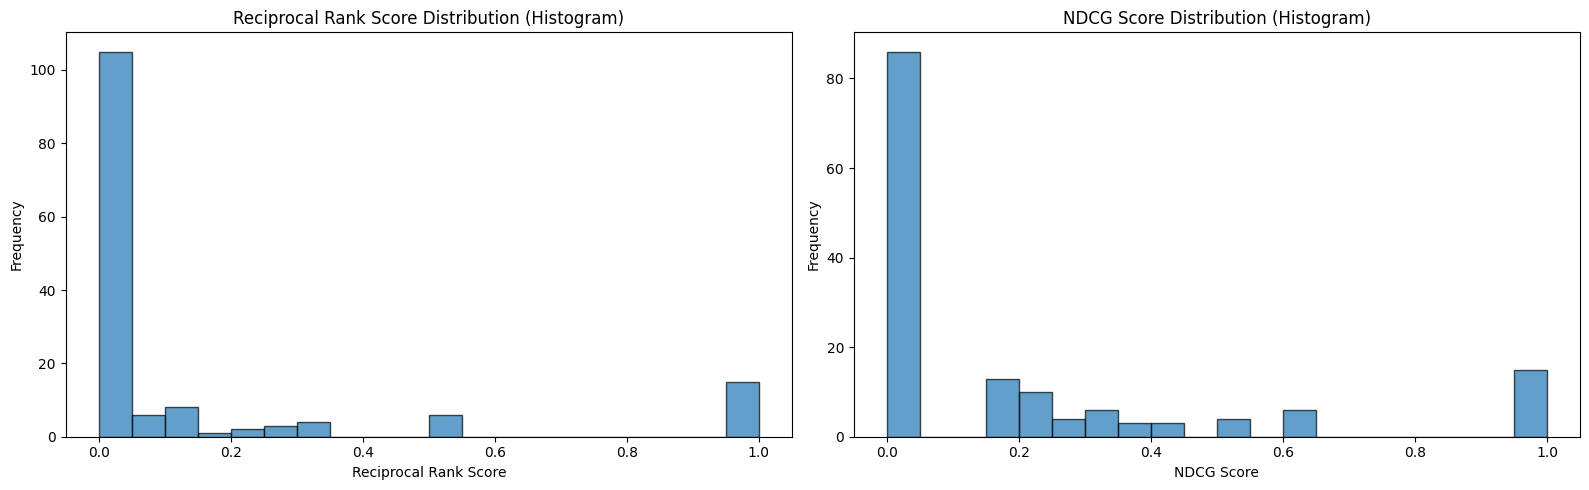

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))


#get rr scores
rr_scores = [entry['recip_rank'] for entry in results.values()]

#get ndcg scores
ndcg_scores = [entry['ndcg'] for entry in results.values()]

# Create a histogram plot
axes[0].hist(rr_scores, bins=20, edgecolor='k', alpha=0.7)
axes[0].set_xlabel('Reciprocal Rank Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Reciprocal Rank Score Distribution (Histogram)')

# Create a histogram plot
axes[1].hist(ndcg_scores, bins=20, edgecolor='k', alpha=0.7)
axes[1].set_xlabel('NDCG Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('NDCG Score Distribution (Histogram)')

plt.tight_layout()
plt.show()


## Divisão dos grupos, criaremos 4 grupos para ndcg:
- ndcg == 0
- ndcg > 0 e ndcg <= 0.247
- ndcg > 0.247 e ndcg < 1
- ndcg == 1

OBS: 0.247 não é um numero arbitrario é o NDCG do melhor baseline.

### Gerando o grupo de consultas cujo NDCG é igual a 0.0

In [77]:
# lets take a look at the queries who got ndcg = 0

# get the queries with ndcg = 0
ndcg_0 = [int(k) for k, v in results.items() if v['ndcg'] == 0]

# get the queries text with ndcg = 0
queries[queries['id'].isin(ndcg_0)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
2,473,"horror movie with a old lady , possibly a ghos...",This is an older 80 s movie. Maybe early 90s. ...,90s,False,False,False,False,False,False
3,659,Funny dads- dvd cover of dads going down water...,I don’t really have any memory of this film. I...,30’s 40s,r rated,comedy comedy,dvd dvd dvd,False,False,False
5,1038,"Chased by cops, saved by truckers",Ive had a movie on my mind for a few days I wa...,80’s 90’s,False,False,False,False,False,False
6,279,Movie about a rapper or a gangsters life?,There was a flashback scene of two young black...,False,False,False,False,False,False,False
7,890,"B & W Movie, Young Couple, A Gangster Named Candy",So I saw this movie probably around 1979. It w...,1979 1920,False,False,False,False,False,False
8,403,Masked/gloved man in fancy secret apartment. M...,"-Date: I’m not entirely sure, but I think I wa...",False,False,False,netflix netflix,german french english,False,False
9,813,I remember this movie,Looking for movie I saw when I was a kid. It m...,60s,False,False,tv,False,False,False
11,985,Guy burned alive 80s or 90s,I’m trying to figure out a movie my husband sa...,80s 90s 90s 80s 90s,False,False,False,False,False,False
12,898,George Clooney movie,One of George Clooney movies in which a woman ...,False,False,False,False,False,False,George Clooney
14,714,ENGLISH MOVIE MEN DISGUISE AS WOMAN AND LIVE W...,I dont remember most of this scene in this mov...,2004 2005 2004 2006,False,False,False,False,False,False


In [78]:
# existem queries q se sairam mal que tem classificação indicativa, genero e descrição do poster!

def get_query_and_link(id = 1):

    print(queries[queries['id'].isin(ndcg_0)][['title']].iloc[id].values[0])
    print(queries[queries['id'].isin(ndcg_0)][['text']].iloc[id].values[0])
    print(queries[queries['id'].isin(ndcg_0)]['wikipedia_url'].iloc[id])
    print("---------------------------------------------------")

### Gerando o grupo de consultas cujo NDCG é menor que 0.2407

In [79]:
# lets take a look at the queries who got ndcg < 0.2407

# get the queries with ndcg < 0.2407
bad_ndcg = [int(k) for k, v in results.items() if v['ndcg'] < 0.2407 and v['ndcg'] > 0]

# get the queries text with ndcg < 0.2407
queries[queries['id'].isin(bad_ndcg)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
4,1095,Fantasy movie involving a giant computer?,I remember seeing a trailer for a fantasy movi...,False,False,sci-fi,False,False,False,False
13,1099,70s/80s comedy with music video,All I remember about this movie is the music v...,70s 80s 80s 70s 80s,False,comedy comedy,False,False,False,False
24,902,Possibly post-apocalyptyic film set in a junkyard,All I remember about the movie was that what s...,False,False,False,tv,False,False,False
25,153,Pretty sure this wasn’t a dream…,"Hear me out on this one, but I am pretty sure ...",90s,False,False,False,False,False,False
26,837,"Very, very long post-apocalyptic movie, possib...",Very late one night I saw part of a very long ...,80’s,False,False,False,False,False,False
27,281,Woman drives over Badger in car.,I re-call a scene in a film where there is a d...,False,False,False,False,False,False,False
47,159,Edo Period set Japanese colour film opening wi...,Edo Period set colour Japanese film from late ...,50’s 60’s,False,False,False,japanese japanese japanese,False,False
48,176,Movie where someone renovates a mall,I believe I saw this movie about 5 years ago (...,2010,False,horror horror,tv tv,english,False,False
56,901,Mystery Girl,I remember a movie that I saw on TV around 200...,2005 2007 2000,False,False,tv,False,False,False
58,627,Girl Imprisoned as Witch,Hello! I am trying to find a movie for one of ...,2011 2000,False,False,False,False,False,False


### Gerando o grupo de consultas cujo NDCG é maior ou igual a 0.247 e menor que 1.0

In [80]:
# lets take a look at the queries who got ndcg > 0.2

# get the queries with ndcg = 0
good_ndcg = [int(k) for k, v in results.items() if v['ndcg'] >= 0.247 and v['ndcg'] < 1]

# get the queries text with ndcg = 0
queries[queries['id'].isin(good_ndcg)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
0,152,Foriegn Film about 3 Strangers in an Apartment,Movie from the early 2000s I believe about th...,2000s,False,False,False,korean chinese,cannes,False
10,1011,Action- Drama Movie,I remember this Action/Gun movie where they we...,False,False,drama,False,False,False,False
31,517,Movie about a financial advisor in prison (Sha...,"The guy ends up in prison for something, and h...",False,False,False,False,False,False,False
34,766,Children’s Animated movie about talking monkey...,Ok I have no clue what this movie is called bu...,90’s 2000,False,False,False,False,False,False
37,665,"Just a door, but when you go threw it, it beca...","I saw a movie when I was very young, it was fr...",70’s 80’s,False,False,False,False,False,False
44,256,Really weird fantasy film,"I remember seeing it as a kid (mid 90s, colour...",90s,False,fantasy,False,False,False,False
49,888,Romance Triangle,I saw this movie on TV years ago. It looked li...,90s 2000s,False,False,tv,False,False,False
63,594,Mini-series – Sci-fi,"Hi, I remember watching part of this mini-seri...",1990,False,sci-fi,False,False,False,False
69,786,Thriller movie about disappearance,"ok, this movie is about a group of young peopl...",False,False,False,False,english,False,False
73,423,What’s this movie!!!!!!!!,I believe the horror movie is from the 1970s I...,1970s 80s,False,horror,False,False,False,False


### Gerando o grupo de consultas cujo NDCG é igual 1.0

In [81]:
# lets take a look at the queries who got ndcg == 1

# get the queries with ndcg = 0
great_ndcg = [int(k) for k, v in results.items() if v['ndcg'] == 1]

# get the queries text with ndcg = 0
queries[queries['id'].isin(great_ndcg)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
1,531,I need help,Alright so I saw this movie sometime in the ea...,2000s,False,False,tv,english,False,False
17,265,80s movie…girl from ocean and a big-ass sea tu...,Late 70s early 80s…prologue has young boy play...,80s 70s 80s,False,False,False,False,False,False
20,919,"For Richer or Poorer, but not that one","(ok, one more–these have all been bugging me. ...",90s,False,False,tv,False,False,Nicolas Cage
42,498,3 Fingered demon,I remember this movie from when I was younger....,80’s,False,False,False,False,False,False
43,644,Kids fighting a war,Ok it was a movie in late 90’s early 00’s all ...,90’s 00’s,False,False,False,False,False,False
50,353,Movie comprised of a number of short sketches…,"Okay, this is driving me nuts… All I remember ...",70’s,False,comedy comedy,False,False,False,Peter Sellars
51,1072,Drugdealer teen girl falls in love with a dancer,Daughter of immigrant mother starts selling dr...,2013,False,drama,False,english french dutch,False,False
54,993,"Man clames to be satin ,purchases souls for $5...",The color movie that I believe I saw in the 90...,90s,False,horror,False,False,False,False
66,649,Movie about building a computer (2000-2008),The movie in question is about an undertaker t...,2000 2008,False,False,False,False,False,False
85,492,Dystopian movie,so there’s this movie about this guy and his b...,False,False,False,False,False,False,False


In [82]:
# existem queries q se sairam mal que tem classificação indicativa, genero e descrição do poster!

def get_query_and_link(id = 1):

    print(queries[queries['id'].isin(great_ndcg)][['title']].iloc[id].values[0])
    print(queries[queries['id'].isin(great_ndcg)][['text']].iloc[id].values[0])
    # print(queries[queries['id'].isin(great_ndcg)]['wikipedia_url'].iloc[id])
    print("---------------------------------------------------")

for i in range(10):
    get_query_and_link(i)

I need help
Alright so I saw this movie sometime in the early 2000s it was in English and it was on tv but I know it was a movie. It was about a woman who at a young age lost her mother and almost died at the funeral but a ghost saved her and from that day on the ghost protected her, then one day once she was an adult she was at a party in an abandoned house I believe and she died at first her spirit is helping her avoid the demons hiding in the darkness after her soul, it was soon reviled that her guardian spirit is actually a demon as well and her mothers spirit is trying to help from what is presumably heaven and the woman has to get to I believe the kitchen and escape through some kind of ventilation shaft or something. Admittedly I was rather young when I saw this and could be mixing up or changing some details unknowingly so if you know a movie that sounds even remotely similar please let me know.
---------------------------------------------------
80s movie…girl from ocean and a

### Porcentagem e quantidade de elementos descritivos de consultas para cada um dos 3 grupos.

In [83]:
size = [
    {
        'size': len(queries),
        'date': len(queries[queries['date'] != False]),
        'parental_rating': len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['genre'] != False]),
        'media': len(queries[queries['media'] != False]),
        'language': len(queries[queries['language'] != False]),
        'awards': len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['human_names'] != False]),
    },
    {
        'size': len(ndcg_0),
        'date': len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(ndcg_0)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(ndcg_0)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(ndcg_0)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(ndcg_0)][queries['human_names'] != False]),
    },
    {
        'size': len(bad_ndcg),
        'date': len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(bad_ndcg)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(bad_ndcg)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(bad_ndcg)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(bad_ndcg)][queries['human_names'] != False]),
    },
    {
        'size': len(good_ndcg),
        'date': len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(good_ndcg)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(good_ndcg)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(good_ndcg)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(good_ndcg)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(good_ndcg)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(good_ndcg)][queries['human_names'] != False]),
    },
    
    {
        'size': len(great_ndcg),
        'date': len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(great_ndcg)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(great_ndcg)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(great_ndcg)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(great_ndcg)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(great_ndcg)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(great_ndcg)][queries['human_names'] != False]),
    }
]

# lets make a df with the data
df = pd.DataFrame(size, index=['all','ndcg == 0', 'ndcg < 0.247', '0.247 <= ndcg < 1', 'ndcg == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
all,150,98,1,42,38,40,1,8
ndcg == 0,86,53,1,19,24,26,0,4
ndcg < 0.247,22,16,0,6,5,6,0,0
0.247 <= ndcg < 1,26,18,0,11,5,5,1,1
ndcg == 1,15,11,0,5,3,2,0,3


In [84]:
percentages = [
    {
        'size': len(ndcg_0),
        'date': len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'genre': len(queries[queries['id'].isin(ndcg_0)][queries['genre'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'media': len(queries[queries['id'].isin(ndcg_0)][queries['media'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'language': len(queries[queries['id'].isin(ndcg_0)][queries['language'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),
        'human_names': len(queries[queries['id'].isin(ndcg_0)][queries['human_names'] != False]) / len(queries[queries['id'].isin(ndcg_0)]),

    },
    {
        'size': len(bad_ndcg),
        'date': len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'genre': len(queries[queries['id'].isin(bad_ndcg)][queries['genre'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'media': len(queries[queries['id'].isin(bad_ndcg)][queries['media'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'language': len(queries[queries['id'].isin(bad_ndcg)][queries['language'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
        'human_names': len(queries[queries['id'].isin(bad_ndcg)][queries['human_names'] != False]) / len(queries[queries['id'].isin(bad_ndcg)]),
    },
    {
        'size': len(good_ndcg),
        'date': len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'parental_rating': len(queries[queries['id'].isin(good_ndcg)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'genre': len(queries[queries['id'].isin(good_ndcg)][queries['genre'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'media': len(queries[queries['id'].isin(good_ndcg)][queries['media'] != False])  / len(queries[queries['id'].isin(good_ndcg)]),
        'language': len(queries[queries['id'].isin(good_ndcg)][queries['language'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'awards': len(queries[queries['id'].isin(good_ndcg)][queries['awards'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        'human_names': len(queries[queries['id'].isin(good_ndcg)][queries['human_names'] != False]) / len(queries[queries['id'].isin(good_ndcg)]),
        
    },
    {
        'size': len(great_ndcg),
        'date': len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'parental_rating': len(queries[queries['id'].isin(great_ndcg)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'genre': len(queries[queries['id'].isin(great_ndcg)][queries['genre'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'media': len(queries[queries['id'].isin(great_ndcg)][queries['media'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'language': len(queries[queries['id'].isin(great_ndcg)][queries['language'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'awards': len(queries[queries['id'].isin(great_ndcg)][queries['awards'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
        'human_names': len(queries[queries['id'].isin(great_ndcg)][queries['human_names'] != False]) / len(queries[queries['id'].isin(great_ndcg)]),
    }
]

# lets make a df with the data
df = pd.DataFrame(percentages, index=['ndcg == 0', 'ndcg < 0.247', '0.247 <= ndcg < 1', 'ndcg == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
ndcg == 0,86,0.616279,0.011628,0.220930,0.279070,0.302326,0.000000,0.046512
ndcg < 0.247,22,0.727273,0.000000,0.272727,0.227273,0.272727,0.000000,0.000000
0.247 <= ndcg < 1,26,0.692308,0.000000,0.423077,0.192308,0.192308,0.038462,0.038462
ndcg == 1,15,0.733333,0.000000,0.333333,0.200000,0.133333,0.000000,0.200000


## Qual a quantidade de consultas que se sai muito mal, mal, bem e ótimo para cada uma das características?

In [85]:
# for queries which have date what are the percentages of ndcg = 0, ndcg < 0.247, 0.247 <= ndcg < 1, ndcg == 1
# i want all queries which date is not false and the queries are in ndcg_0

print(f"{len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem ndcg = 0")
print(f"{len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem 0 < ndcg < 0.247")
print(f"{len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem 0.247 <= ndcg < 1")
print(f"{len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False])}% das consultas com data tem ndcg = 1")


# for queries which have parental_rating what are the percentages of ndcg = 0, ndcg < 0.247, 0.247 <= ndcg < 1, ndcg == 1

0.5408163265306123% das consultas com data tem ndcg = 0
0.16326530612244897% das consultas com data tem 0 < ndcg < 0.247
0.1836734693877551% das consultas com data tem 0.247 <= ndcg < 1
0.11224489795918367% das consultas com data tem ndcg = 1


## proporção de consultas com cada feature entre os 4 grupos:

Agora fazermos (#consultas t.q. date != False e ndcg = 0) / (#consultas t.q date != False)

In [86]:
percentages = [
    {
        'date': len(queries[queries['id'].isin(ndcg_0)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(ndcg_0)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(ndcg_0)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(ndcg_0)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(ndcg_0)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(bad_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(bad_ndcg)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(bad_ndcg)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language':len(queries[queries['id'].isin(bad_ndcg)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(bad_ndcg)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(good_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(good_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(good_ndcg)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(good_ndcg)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(good_ndcg)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(good_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(good_ndcg)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(great_ndcg)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(great_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(great_ndcg)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(great_ndcg)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(great_ndcg)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(great_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(great_ndcg)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    }
]

df = pd.DataFrame(percentages, index=['ndcg == 0', 'ndcg < 0.247', '0.247 <= ndcg < 1', 'ndcg == 1'])
df

,date,genre,media,language,human_names
ndcg == 0,0.540816,0.452381,0.631579,0.650,0.500
ndcg < 0.247,0.163265,0.142857,0.131579,0.150,0.000
0.247 <= ndcg < 1,0.183673,0.261905,0.131579,0.125,0.125
ndcg == 1,0.112245,0.119048,0.078947,0.050,0.375


## Divisão dos grupos, criaremos 2 grupos para recalls:
- recall == 0
- ndcg == 1



### gerando o grupo de consultas com recall = 0

In [87]:
# lets take a look at the queries who got ndcg = 0

# get the queries with recall = 0
recall_0 = [int(k) for k, v in results.items() if v['recall_1000'] == 0]

# get the queries text with ndcg = 0
queries[queries['id'].isin(recall_0)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
2,473,"horror movie with a old lady , possibly a ghos...",This is an older 80 s movie. Maybe early 90s. ...,90s,False,False,False,False,False,False
3,659,Funny dads- dvd cover of dads going down water...,I don’t really have any memory of this film. I...,30’s 40s,r rated,comedy comedy,dvd dvd dvd,False,False,False
5,1038,"Chased by cops, saved by truckers",Ive had a movie on my mind for a few days I wa...,80’s 90’s,False,False,False,False,False,False
6,279,Movie about a rapper or a gangsters life?,There was a flashback scene of two young black...,False,False,False,False,False,False,False
7,890,"B & W Movie, Young Couple, A Gangster Named Candy",So I saw this movie probably around 1979. It w...,1979 1920,False,False,False,False,False,False
8,403,Masked/gloved man in fancy secret apartment. M...,"-Date: I’m not entirely sure, but I think I wa...",False,False,False,netflix netflix,german french english,False,False
9,813,I remember this movie,Looking for movie I saw when I was a kid. It m...,60s,False,False,tv,False,False,False
11,985,Guy burned alive 80s or 90s,I’m trying to figure out a movie my husband sa...,80s 90s 90s 80s 90s,False,False,False,False,False,False
12,898,George Clooney movie,One of George Clooney movies in which a woman ...,False,False,False,False,False,False,George Clooney
14,714,ENGLISH MOVIE MEN DISGUISE AS WOMAN AND LIVE W...,I dont remember most of this scene in this mov...,2004 2005 2004 2006,False,False,False,False,False,False


### gerando o grupo de consultas com recall = 1

In [88]:
# lets take a look at the queries who got ndcg = 0

# get the queries with recall = 0
recall_1 = [int(k) for k, v in results.items() if v['recall_1000'] == 1]

# get the queries text with ndcg = 0
queries[queries['id'].isin(recall_1)][['id','title', 'text', 'date', 'parental_rating','genre', 'media', 'language', 'awards', 'human_names']].head(10)

,id,title,text,date,parental_rating,genre,media,language,awards,human_names
0,152,Foriegn Film about 3 Strangers in an Apartment,Movie from the early 2000s I believe about th...,2000s,False,False,False,korean chinese,cannes,False
1,531,I need help,Alright so I saw this movie sometime in the ea...,2000s,False,False,tv,english,False,False
4,1095,Fantasy movie involving a giant computer?,I remember seeing a trailer for a fantasy movi...,False,False,sci-fi,False,False,False,False
10,1011,Action- Drama Movie,I remember this Action/Gun movie where they we...,False,False,drama,False,False,False,False
13,1099,70s/80s comedy with music video,All I remember about this movie is the music v...,70s 80s 80s 70s 80s,False,comedy comedy,False,False,False,False
17,265,80s movie…girl from ocean and a big-ass sea tu...,Late 70s early 80s…prologue has young boy play...,80s 70s 80s,False,False,False,False,False,False
20,919,"For Richer or Poorer, but not that one","(ok, one more–these have all been bugging me. ...",90s,False,False,tv,False,False,Nicolas Cage
24,902,Possibly post-apocalyptyic film set in a junkyard,All I remember about the movie was that what s...,False,False,False,tv,False,False,False
25,153,Pretty sure this wasn’t a dream…,"Hear me out on this one, but I am pretty sure ...",90s,False,False,False,False,False,False
26,837,"Very, very long post-apocalyptic movie, possib...",Very late one night I saw part of a very long ...,80’s,False,False,False,False,False,False


### Porcentagem e quantidade de elementos descritivos de consultas para cada um dos 3 grupos.

In [89]:
size = [
    {
        'size': len(queries),
        'date': len(queries[queries['date'] != False]),
        'parental_rating': len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['genre'] != False]),
        'media': len(queries[queries['media'] != False]),
        'language': len(queries[queries['language'] != False]),
        'awards': len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['human_names'] != False]),
    },
    {
        'size': len(recall_0),
        'date': len(queries[queries['id'].isin(recall_0)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(recall_0)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_0)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_0)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(recall_0)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(recall_0)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_0)][queries['human_names'] != False]),
    },
    {
        'size': len(recall_1),
        'date': len(queries[queries['id'].isin(recall_1)][queries['date'] != False]),
        'parental_rating': len(queries[queries['id'].isin(recall_1)][queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_1)][queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_1)][queries['media'] != False]),
        'language': len(queries[queries['id'].isin(recall_1)][queries['language'] != False]),
        'awards': len(queries[queries['id'].isin(recall_1)][queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_1)][queries['human_names'] != False]),
    }
]

# lets make a df with the data
df = pd.DataFrame(size, index=['all','recall_1000 == 0', 'recall_1000 == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
all,150,98,1,42,38,40,1,8
recall_1000 == 0,86,53,1,19,24,26,0,4
recall_1000 == 1,64,45,0,23,14,14,1,4


In [90]:
percentages = [
    {
        'size': len(recall_0),
        'date': len(queries[queries['id'].isin(recall_0)][queries['date'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'parental_rating': len(queries[queries['id'].isin(recall_0)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'genre': len(queries[queries['id'].isin(recall_0)][queries['genre'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'media': len(queries[queries['id'].isin(recall_0)][queries['media'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'language': len(queries[queries['id'].isin(recall_0)][queries['language'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'awards': len(queries[queries['id'].isin(recall_0)][queries['awards'] != False]) / len(queries[queries['id'].isin(recall_0)]),
        'human_names': len(queries[queries['id'].isin(recall_0)][queries['human_names'] != False]) / len(queries[queries['id'].isin(recall_0)]),

    },
    {
        'size': len(recall_1),
        'date': len(queries[queries['id'].isin(recall_1)][queries['date'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'parental_rating': len(queries[queries['id'].isin(recall_1)][queries['parental_rating'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'genre': len(queries[queries['id'].isin(recall_1)][queries['genre'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'media': len(queries[queries['id'].isin(recall_1)][queries['media'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'language': len(queries[queries['id'].isin(recall_1)][queries['language'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'awards': len(queries[queries['id'].isin(recall_1)][queries['awards'] != False]) / len(queries[queries['id'].isin(recall_1)]),
        'human_names': len(queries[queries['id'].isin(recall_1)][queries['human_names'] != False]) / len(queries[queries['id'].isin(recall_1)]),
    }
]

# lets make a df with the data
df = pd.DataFrame(percentages, index=['recall_1000 == 0', 'recall_1000 == 1'])
df

,size,date,parental_rating,genre,media,language,awards,human_names
recall_1000 == 0,86,0.616279,0.011628,0.220930,0.27907,0.302326,0.000000,0.046512
recall_1000 == 1,64,0.703125,0.000000,0.359375,0.21875,0.218750,0.015625,0.062500


## proporção de consultas com as features

In [91]:
percentages = [
    {
        'date': len(queries[queries['id'].isin(recall_0)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(ndcg_0)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_0)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_0)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language': len(queries[queries['id'].isin(recall_0)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(ndcg_0)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_0)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    },
    {
        'date': len(queries[queries['id'].isin(recall_1)][queries['date'] != False])/len(queries[queries['date'] != False]),
        # 'parental_rating': len(queries[queries['id'].isin(bad_ndcg)][queries['parental_rating'] != False])/len(queries[queries['parental_rating'] != False]),
        'genre': len(queries[queries['id'].isin(recall_1)][queries['genre'] != False])/len(queries[queries['genre'] != False]),
        'media': len(queries[queries['id'].isin(recall_1)][queries['media'] != False])/len(queries[queries['media'] != False]),
        'language':len(queries[queries['id'].isin(recall_1)][queries['language'] != False])/len(queries[queries['language'] != False]),
        # 'awards': len(queries[queries['id'].isin(bad_ndcg)][queries['awards'] != False])/len(queries[queries['awards'] != False]),
        'human_names': len(queries[queries['id'].isin(recall_1)][queries['human_names'] != False])/len(queries[queries['human_names'] != False]),
    }
]

df = pd.DataFrame(percentages, index=['recall_1000 == 0', 'recall_1000 == 1'])
df

,date,genre,media,language,human_names
recall_1000 == 0,0.540816,0.452381,0.631579,0.65,0.5
recall_1000 == 1,0.459184,0.547619,0.368421,0.35,0.5


## para grupos com e sem cada feature como é o recall?